In [41]:
import glob
import pandas as pd
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

subdirs = os.path.join('../results',  '*')

def read_hyperparams(subdir, fn='hyperparameters.pkl'):
    try:
        with open(os.path.join(subdir, fn), 'rb') as f:
            res = pickle.load(f)
        return res
    except FileNotFoundError:
        print("No hyperparams in {}".format(subdir))
        return {}
    
def read_result(subdir, fn='results.pkl', empty_dirs=[]):
    try:
        with open(os.path.join(subdir, fn), 'rb') as f:
            res = pickle.load(f)
        return res
    except FileNotFoundError:
        empty_dirs.append(read_hyperparams(subdir))
        return []

rows = []
empty_dirs = []
ok_dirs = []
for subdir in glob.glob(subdirs):
    hyperparams = read_hyperparams(subdir)
    res = read_result(subdir, empty_dirs=empty_dirs)

    if len(hyperparams) > 0 and len(res) > 0:
        if not hyperparams['gp']:
            ok_dirs.append({k: v for k, v in dict(hyperparams).items() if k in ['function', 'seed', 'noise',
                                                                               'retrain', 'epochs', 'batch_size',
                                                                               'iid_ratio']})
        hyperparams['results'] = res
        rows.append(hyperparams)

df = pd.DataFrame(rows)


In [43]:
to_show = ['function', 'gp', 'retrain', 'epochs', 'batch_size', 'iid_ratio', 'noise', 'results']
df = df[to_show]

# When results are incomplete, append NANs so that all results have the same length
MAX_N_STEPS = 1000 #101
df['results'] = df['results'].apply(lambda lis: lis if len(lis) == MAX_N_STEPS else lis + [np.nan] * (MAX_N_STEPS - len(lis)))
print('Mean value for the length of the results : ', df['results'].apply(len).mean())
print('How many results we have in total ? ', len(df))

Mean value for the length of the results :  1000.0
How many results we have in total ?  976


In [44]:
def plot_one(fct, noise, retrain=False, batch_size=64, iid_ratio=10, epochs=50, ax=None):
    if ax is None:
        plt.figure(figsize=(20,10)) 
        ax = plt.gca()
    df1 = df[df['function'] == fct]
    df1 = df1[df1['noise'] == noise]
    out = df1.groupby(['gp', 'retrain', 'iid_ratio',
                 'batch_size', 'epochs'])['results'].apply(lambda x: 
                                                           (np.nanmean(x.tolist(), axis=0), np.std(x.tolist(), axis=0)))

    def key_to_str(key):
        st = ""
        if key[0]:
            st += 'GP'
        else:
            st += 'EP'
            if key[1]:
                st += '_retrain'
            st += str(key[2:])
        return st

    # plt.figure(figsize=(20,10))
    for key, value in zip(out.keys(), out.values):
        if not key[0]:
            if retrain and not key[1] or not retrain and key[1]:
                continue
            if key[2] != iid_ratio:
                continue
            if key[3] != batch_size:
                continue
            if key[4] != epochs:
                continue
        #if not key[1] and not key[0]:
        #    continue
        ax.errorbar(range(MAX_N_STEPS), value[0], yerr=.1 * value[1],
                     linewidth=3 if key[0] else 2 if key[1] else 1,
                     linestyle='dotted' if key[2] < 1 else 'solid', 
                     label=key_to_str(key))
    ax.legend()
    ax.set_title('{} - {}'.format(fct, noise))

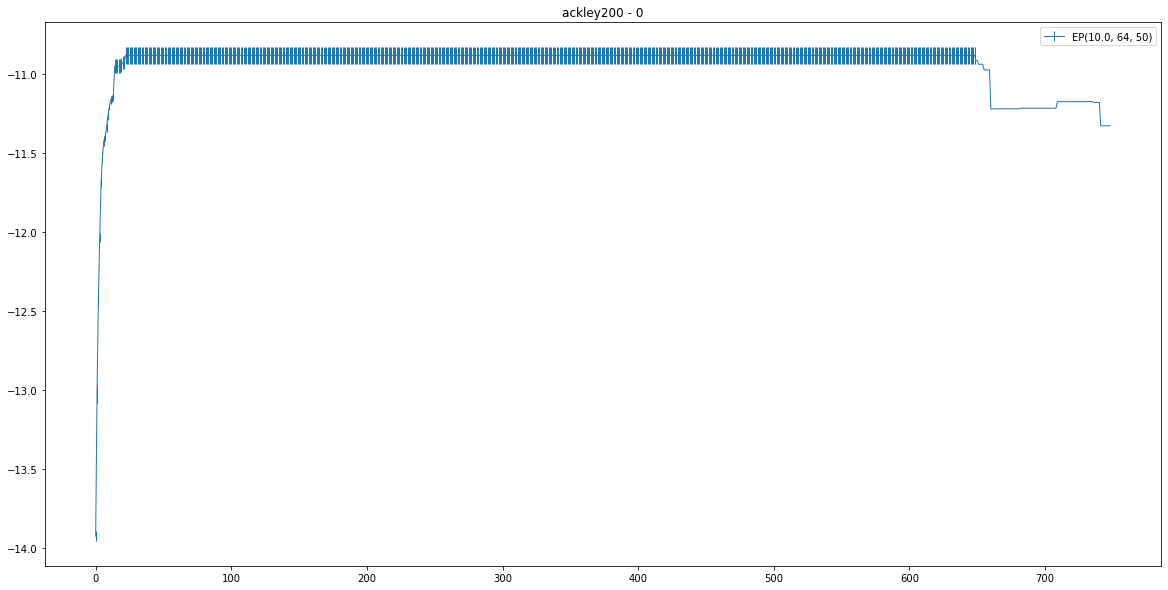

In [45]:
plot_one('ackley200', 0)

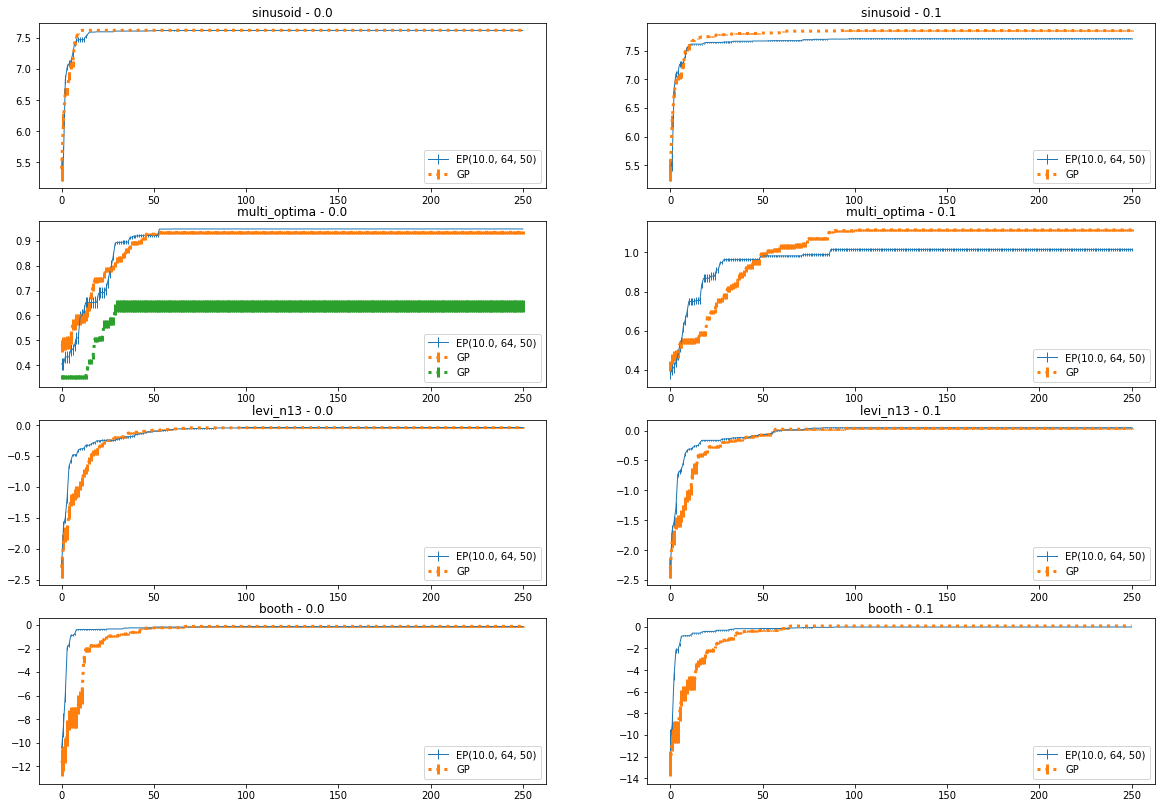

In [33]:
f, axes = plt.subplots(4, 2, figsize=(20, 14))
plot_one('sinusoid', 0.0, ax=axes[0][0])
plot_one('sinusoid', 0.1, ax=axes[0][1])
plot_one('multi_optima', 0.0, ax=axes[1][0])
plot_one('multi_optima', 0.1, ax=axes[1][1])
plot_one('levi_n13', 0.0, ax=axes[2][0])
plot_one('levi_n13', 0.1, ax=axes[2][1])
plot_one('booth', 0.0, ax=axes[3][0])
plot_one('booth', 0.1, ax=axes[3][1])

In [ ]:
def plot_many(fct, noise, lim1=None, lim2=None): 
    #lim 1 and lim 2 filters very bad runs !
    df1 = df[df['function'] == fct]
    df1 = df1[df1['noise'] == noise]
    out = df1.groupby(['gp', 'retrain', 'iid_ratio',
                 'batch_size', 'epochs'])['results'].apply(lambda x: 
                                                           (np.nanmean(x.tolist(), axis=0), np.std(x.tolist(), axis=0)))

    def key_to_str(key):
        st = ""
        if key[0]:
            st += 'GP'
        else:
            st += 'EP'
            if key[1]:
                st += '_retrain'
            st += str(key[2:])
        return st

    plt.figure(figsize=(20,10))
    for key, value in zip(out.keys(), out.values):
        if lim1 is not None and lim2 is not None:
            if (
                not key[1] and
                (value[0][40] < lim1 or np.isnan(value[0][-1]) or value[0][-1] < lim2)
               ):
                continue
                pass
        #if not key[1] and not key[0]:
        #    continue
        plt.errorbar(range(101), value[0], yerr=.1 * value[1],
                     linewidth=3 if key[0] else 2 if key[1] else 1,
                     linestyle='dotted' if key[2] < 1 else 'solid', 
                     label=key_to_str(key))
    plt.legend()
    plt.title('{} - {}'.format(fct, noise))
    plt.show()
    


In [ ]:
plot_many('multi_optima', 0.1, 0.85, 1.05)

In [ ]:
plot_many('multi_optima', 0.0, 0.85, 0.93)

In [ ]:
plot_many('levi_n13', 0.0, -0.2, -0.1)

In [ ]:
plot_many('levi_n13', 0.1, -0.2, 0.)